# **Linear Regression in a nutshell**

by Felix Fritzen <fritzen@simtech.uni-stuttgart.de>, August 2020

additional material for the course _Data processing for engineers and scientists_ at the University of Stuttgart


## **Objective**
given samples $$(x_i, y_i)$$ determine the best linear approximation
$$\widehat{y} = a x + b$$
regarding the mean squared error
$$(a, b) = \text{arg min} \sum_i  ( a x_i + b - y_i )^2$$

In [1]:
import numpy as np
import numpy.linalg as LA
import numpy.random as rnd

import datetime
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'], 'size':14})


## Generate and visualize data

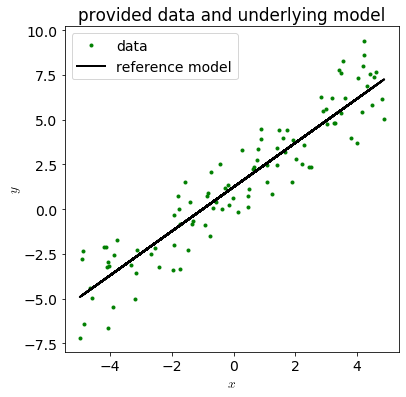

In [2]:
n_sample = 100
a_ref    = 1.234
b_ref    = 1.234
noise    = 1.5
x_min    = -5
x_max    = 5
x        = rnd.uniform(x_min, x_max, size=n_sample)
y        = a_ref * x + b_ref + rnd.normal(0, noise, size=n_sample)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(x,y,'o',color='green', markersize=3)
ax.plot(x, a_ref*x+b_ref, '-', color='black', linewidth=2)
ax.set_xlabel('$x$',fontsize=14, usetex=True)
ax.set_ylabel('$y$', fontsize=14, usetex=True)
ax.set_title('provided data and underlying model')
ax.legend(['data', 'reference model'], fontsize=14)

## Ansatz
- formulate the cost function as matrix product for given $$\underline{x}, \underline{y} \in\mathbb{R}^n$$
$$\Phi(a,b \vert (\underline{x}, \underline{y}) ) = \begin{pmatrix} a \\ b \end{pmatrix}^\mathsf{T} \left( \underline{\underline{M}} \begin{pmatrix} a \\ b \end{pmatrix} - 2 \underline{v} \right) + c $$
with
$$ \underline{\underline{M}} = \begin{pmatrix} \underline{x}^\mathsf{T} \underline{x} & \text{sum}(\underline{x}) \\ \text{sum}(\underline{x}) & n \end{pmatrix} \qquad  \underline{v} = \begin{pmatrix} \underline{x}^\mathsf{T} \underline{y} \\ \text{sum}(\underline{y}) \end{pmatrix} \qquad c = \underline{y}^\mathsf{T} \underline{y}$$
- necessary condition for a minimum:
$$ \frac{\displaystyle \partial \Phi}{\partial (a, b)} = 2\, \underline{\underline{M}} \begin{pmatrix} a \\ b \end{pmatrix} - 2 \underline{v} = \underline{0}$$
- solution:
$$ \begin{pmatrix} a \\ b \end{pmatrix} = \underline{\underline{M}}^{-1} \underline{v} = \frac{1}{\displaystyle M_{11}M_{22} - M_{12}M_{21}} \begin{pmatrix} M_{22} & - M_{21} \\ - M_{12} & M_{11}\end{pmatrix} \underline{v}$$

### Check: stationary point is a minimum
The second gradient of $\Phi$ is unconditionally symmetric. If it is (strictly) positive, then the function is (strictly) convex and, therefore, any stationary point must be a minimizer.

Consider a discrete RV $Z$ with values $x_i$ for $i=1, \dots, n$ and with discrete probabilities $P_i$. Then the covariance matrix of $Z$ and a constant RV~$O=1$ is
$$\underline{\underline{C}}( Z, O ) = \frac{1}{n} \underline{\underline{M}}$$

We know that the covariance matrix is symmetric and (at least semi) positive. In this case, if the are at least two distinct $x$-coordinates, then the mtrix is strictly positive. Therefore, **the stationary point is unconditionally a minmum**.

In [3]:
def linear_regression( x, y):
    """
    compute the least square optimal linear regression
    for given tuples (x_i, y_i) (i=1, ..., n)
    
    
    Parameters:
    x (float, numpy.array):    x-values of the samples
    y (float, numpy.array):    y-values of the samples [must be same size as x]
    
    Returns:
    a, b (float):                parameters of the linear regression such that y=a*x+b is the model
    err (float, numpy.array):    array containing the differences y[i] - (a*x[i] +b)
    MSE (float):                 means squared error
    M (float, numpy.array(2,2)): 2x2 matrix M
    v (float, numpy.array(2)):   2 vector v
    c (float):                   scalar c
    
    """
    assert(x.shape[0] == y.shape[0])
    n      = x.shape[0]
    M      = np.zeros([2,2])
    v      = np.zeros(2)
    M[0,0] = x.dot(x)
    M[0,1] = x.sum()
    M[1,0] = M[0,1]
    M[1,1] = n
    v[0]   = x.dot(y)
    v[1]   = y.sum()
    c      = y.dot(y)
    detM   = LA.det(M)
    a      = (  M[1,1]*v[0] - M[1,0]*v[1] ) / detM
    b      = (- M[0,1]*v[0] + M[0,0]*v[1] ) / detM
    err    = y - (a*x+b)
    MSE    = err.dot(err)/n
    return a, b, err, MSE, M, v, c

In [4]:
n = x.shape[0]
a, b, err, MSE, M, v, c = linear_regression(x, y)
var_y = ((y-y.mean())**2).sum()/(n-1)

print('least square optimal solution:')
print('MSE: %12.8f   (vs. variance %12.8f of y)' % (MSE, var_y) )
print('a = %18.10e   vs   a_ref = %18.10e   -->  %5.3f %% error' \
      % (a, a_ref, np.abs(a-a_ref)/np.abs(a_ref)*100.))
print('b = %18.10e   vs   b_ref = %18.10e   -->  %5.3f %% error' \
      % (b, b_ref, np.abs(b-b_ref)/np.abs(b_ref)*100.))

least square optimal solution:
MSE:   1.89320032   (vs. variance  15.25192464 of y)
a =   1.2634782139e+00   vs   a_ref =   1.2340000000e+00   -->  2.389 % error
b =   1.2510771108e+00   vs   b_ref =   1.2340000000e+00   -->  1.384 % error


## Plausibility checks
- verify that the sum of the squared errors computed using $\underline{\underline{M}}$ is correct
- compute the cost function for $(a,b)$ and for $(a_{\sf ref}, b_{\sf ref})$;
the computed $(a,b)$ should yield a lower (i.e. better) error
- compute the coefficient of determination $R^2$
- plot the new line for visual inspection

----------------------------------------------------------------------------------
MSE:   1.89320032 vs.   1.89320032 (computed via M)
MSE(a=a_ref, b=b_ref) =   1.90094029 >=   1.89320032 =  MSE(a,b) of the regression
coefficient of determination:   0.8746176
----------------------------------------------------------------------------------
MSE: data vs. regression model  --> 1.89320e+00
MSE: data vs. unperturbed model --> 1.90094e+00
relative difference             -->      0.409 %
----------------------------------------------------------------------------------
true model         a =  1.234   ,  b =  1.234
regression model   a =  1.263   ,  b =  1.251
relative deviation a:   0.023 % ,  b:   0.014 %
----------------------------------------------------------------------------------
(NOTE: this relative error should decay with the number of samples)
----------------------------------------------------------------------------------


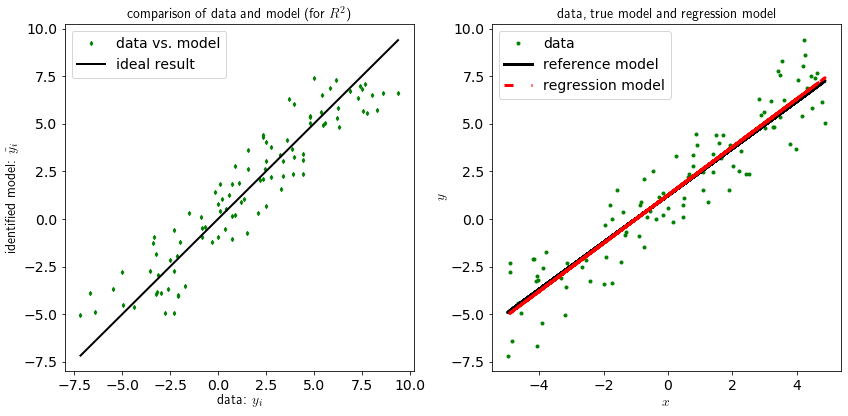

In [5]:
y_tilde = a*x + b

# check 1: compare error using M vs. direct computation
A = np.array([a,b])
MSE_check = (A@(M@A - 2*v) + c)/n
A_ref = np.array([a_ref, b_ref])
MSE_ref = (A_ref@(M@A_ref - 2*v) + c)/n
print('----------------------------------------------------------------------------------')
print('MSE: %12.8f vs. %12.8f (computed via M)' % (MSE, MSE_check) )
print('MSE(a=a_ref, b=b_ref) = %12.8f >= %12.8f =  MSE(a,b) of the regression' % \
     (MSE_ref, MSE))

# check 2: coefficient of determination
y_mean   = np.mean(y)
R        = 1 - MSE / ( np.sum((y-y_mean)**2)/n )
print('coefficient of determination:  %10.7f' % R )
fig, ax = plt.subplots( 1, 2, figsize = (12,6) )
ax[0].plot(y,y_tilde, 'd', color='green', markersize=3)
y_min = np.min( [ np.min( y ), np.min( y_tilde ) ] )
y_max = np.max( [ np.max( y ), np.max( y_tilde ) ] )
ax[0].plot([y_min,y_max],[y_min,y_max],'-', color='black', linewidth=2)
ax[0].set_xlabel('data: $y_i$',fontsize=14, usetex=True)
ax[0].set_ylabel('identified model: $\\tilde{y}_i$', fontsize=14, usetex=True)
ax[0].set_title('comparison of data and model (for $R^2$)', fontsize=14, usetex=True)
ax[0].legend(['data vs. model', 'ideal result'], fontsize=14)

# check 3: plotting for visual inspection
ax[1].plot(x,y,'o',color='green', markersize=3)
ax[1].plot(x, a_ref*x+b_ref, '-', color='black', linewidth=3)
ax[1].plot(x, y_tilde, '-', dashes = [3, 6], color='red', linewidth=3)
ax[1].set_xlabel('$x$',fontsize=14, usetex=True)
ax[1].set_ylabel('$y$', fontsize=14, usetex=True)
ax[1].set_title('data, true model and regression model', fontsize=14, usetex=True)
ax[1].legend(['data', 'reference model', 'regression model'], fontsize=14)

fig.tight_layout()

# check 4: errors
print('----------------------------------------------------------------------------------')
print('MSE: data vs. regression model  --> %10.5e' % ( MSE ) )
print('MSE: data vs. unperturbed model --> %10.5e' % ( MSE_ref) )
print('relative difference             -->     %6.3f %%' % ( 100.0*(np.abs(MSE-MSE_ref)/MSE) ) )
print('----------------------------------------------------------------------------------')
print('true model         a = %6.3f   ,  b = %6.3f' % ( a_ref, b_ref ) )
print('regression model   a = %6.3f   ,  b = %6.3f' % ( a, b ) )
print('relative deviation a:  %6.3f %% ,  b:  %6.3f %%' % ( np.abs((a-a_ref)/a), np.abs((b_ref-b)/b) ) )
print('----------------------------------------------------------------------------------')
print('(NOTE: this relative error should decay with the number of samples)')
print('----------------------------------------------------------------------------------')



## Counterexample: When linear regression is not sufficient!

We investigate discrete data for the functions $f(x)=\sin(x)$ and $g(x)=\cos(x)$ on the interval $[0, 2\pi]$.
Linear regression will fail on this (although the result could come with some surprise).

regression model for sine:   a =    -0.360750,  b =     1.174891
regression model for cosine: a =     0.044006,  b =    -0.214178
MSE of sine:     0.1880
MSE of cosine:   0.4261


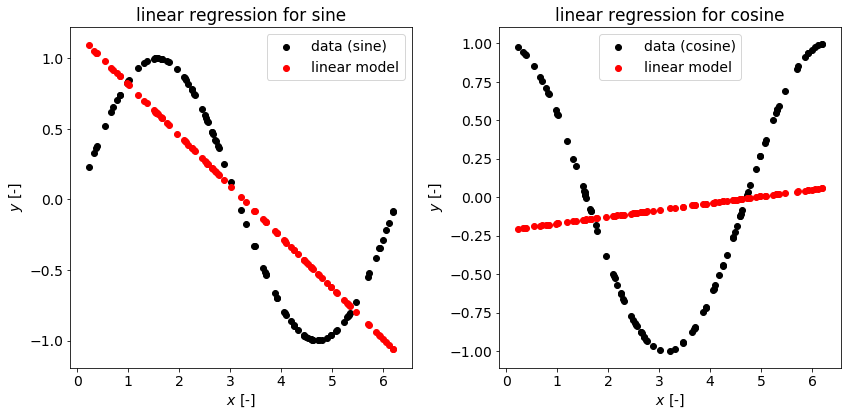

In [7]:
n = 100
x = np.random.uniform(0,2*np.pi,size=n)
#x = np.linspace(0,2*np.pi,n)
f = np.sin(x)
g = np.cos(x)
a, b, err, MSE_s, M, v, c = linear_regression( x, f )
print('regression model for sine:   a = %12.6f,  b = %12.6f' % (a, b))
f_tilde = a*x+b
a, b, err, MSE_c, M, v, c = linear_regression( x, g )
print('regression model for cosine: a = %12.6f,  b = %12.6f' % (a, b))
g_tilde = a*x+b
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(x,f,color='black',label='data (sine)')
ax[0].scatter(x,f_tilde,color='red',label='linear model')
ax[0].set_title('linear regression for sine')
ax[0].set_xlabel('$x$ [-]')
ax[0].set_ylabel('$y$ [-]')
ax[0].legend()

ax[1].scatter(x,g,color='black',label='data (cosine)')
ax[1].scatter(x,g_tilde,color='red',label='linear model')
ax[1].set_xlabel('$x$ [-]')
ax[1].set_ylabel('$y$ [-]')
ax[1].set_title('linear regression for cosine')
ax[1].legend()

fig.tight_layout()
print( 'MSE of sine:   %8.4f' % MSE_s)
print( 'MSE of cosine: %8.4f' % MSE_c)